# Mental Health in the Tech Industry  
## **Unsupervised Learning - Clustering**
---
### Importing Libraries
(one last time🥹)

In [ ]:
import numpy as np
import pandas as pd
from sklearn.metrics import silhouette_score
import matplotlib.pyplot as plt
from sklearn.preprocessing import StandardScaler
from sklearn.cluster import KMeans
from sklearn.decomposition import PCA
from sklearn.cluster import DBSCAN
import umap
from sklearn.manifold import TSNE
from sklearn.cluster import AgglomerativeClustering
from sklearn.ensemble import IsolationForest
#removes the unwanted warnings for better presentation
import warnings
warnings.filterwarnings('ignore')
print("All Libraries successfully imported and ready to use 💪")

All Libraries successfully imported and ready to use 💪


### Data Loading and description

In [1119]:
df = pd.read_csv("cleaned_survey.csv")
df.info()
shape = df.shape

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1024 entries, 0 to 1023
Data columns (total 23 columns):
 #   Column                     Non-Null Count  Dtype 
---  ------                     --------------  ----- 
 0   Age                        1024 non-null   int64 
 1   Gender                     1024 non-null   object
 2   Country                    1024 non-null   object
 3   self_employed              1024 non-null   object
 4   family_history             1024 non-null   object
 5   treatment                  1024 non-null   object
 6   work_interfere             1024 non-null   object
 7   no_employees               1024 non-null   object
 8   remote_work                1024 non-null   object
 9   benefits                   1024 non-null   object
 10  care_options               1024 non-null   object
 11  wellness_program           1024 non-null   object
 12  seek_help                  1024 non-null   object
 13  anonymity                  1024 non-null   object
 14  leave   

In [1120]:
df.sample(10)

,Age,Gender,Country,self_employed,family_history,treatment,work_interfere,no_employees,remote_work,benefits,...,anonymity,leave,mental_health_consequence,phys_health_consequence,coworkers,supervisor,mental_health_interview,phys_health_interview,mental_vs_physical,obs_consequence
462,28,Other,United Kingdom,No,Yes,Yes,Rarely,100-500,No,No,...,Yes,Medium,Yes,Yes,Some of them,Some of them,Yes,No,No,Yes
80,29,Female,United States,No,No,Yes,Sometimes,26-100,No,Yes,...,Don't know,Medium,Maybe,No,Some of them,Some of them,No,Maybe,No,Yes
931,23,Male,Germany,No,Yes,Yes,Sometimes,6-25,No,Don't know,...,Don't know,Medium,Maybe,No,No,No,No,No,Don't know,No
946,31,Male,United Kingdom,No,No,No,Never,100-500,No,Yes,...,Don't know,Medium,Maybe,Yes,Some of them,No,No,No,Yes,No
584,29,Male,Netherlands,No,No,No,Never,1-5,Yes,No,...,Yes,Medium,No,No,Yes,Yes,No,Maybe,Yes,No
838,31,Male,United States,No,No,No,Sometimes,More than 1000,No,Yes,...,Yes,Medium,Yes,Maybe,Some of them,Some of them,No,Maybe,Yes,No
256,60,Male,United States,No,No,No,Sometimes,More than 1000,No,Yes,...,Don't know,Medium,No,No,Some of them,Yes,Maybe,Maybe,Yes,No
561,26,Male,Ireland,Yes,No,No,Never,1-5,Yes,No,...,Don't know,Medium,Maybe,No,Some of them,Yes,Maybe,Maybe,Yes,No
847,42,Male,United States,No,Yes,Yes,Sometimes,6-25,Yes,Don't know,...,Don't know,Medium,Maybe,Maybe,Some of them,Some of them,No,No,Don't know,No
836,33,Female,United States,Yes,No,No,Never,1-5,Yes,No,...,Yes,Medium,Maybe,No,No,Some of them,No,No,Yes,No


### Dropping some features
These features don't contribute to our objective i.e. mental health personas of employees

In [1121]:
df_clus = df.drop(columns = ['Age','Gender','Country','self_employed'], errors='ignore')

print("Age, Gender, Country and self_employed features dropped!")
print("Features used for clustering:", df_clus.columns.tolist())

Age, Gender, Country and self_employed features dropped!
Features used for clustering: ['family_history', 'treatment', 'work_interfere', 'no_employees', 'remote_work', 'benefits', 'care_options', 'wellness_program', 'seek_help', 'anonymity', 'leave', 'mental_health_consequence', 'phys_health_consequence', 'coworkers', 'supervisor', 'mental_health_interview', 'phys_health_interview', 'mental_vs_physical', 'obs_consequence']


### Ordinal Feature Mapping

In [1122]:
print("Unique values of work_interfere column:",df_clus['work_interfere'].unique())
print("Unique values of leave column:",df_clus['leave'].unique())

work_interfere_map = {
    'Never': 3,
    'Rarely': 2,
    'Sometimes': 1,
    'Often': 0
}

leave_map = {
    'Easy': 2,
    'Medium': 1,
    'Difficult': 0
}

df_clus['work_interfere'] = df_clus['work_interfere'].map(work_interfere_map)
df_clus['leave'] = df_clus['leave'].map(leave_map)
print("\nProcessing...\nValue Mapping for ordinal features done✅✍️")

Unique values of work_interfere column: ['Often' 'Rarely' 'Never' 'Sometimes']
Unique values of leave column: ['Medium' 'Difficult' 'Easy']

Processing...
Value Mapping for ordinal features done✅✍️


### Guess who's back! - Our custom Support_Score feature

In [1123]:
value_map = {
    'Yes': 1,
    'No': 0,
    "Don't know": 0.5,
    'Not sure': 0.5,
    'Some of them': 0,
}

support_score_cols = [
    'benefits', 'care_options', 'wellness_program',
    'seek_help', 'anonymity', 'supervisor', 'coworkers'
]

final_df = df_clus.copy()
for col in support_score_cols:
    final_df[f"{col}_scaled"] = final_df[col].map(value_map)

# Calculate average support score
scaled_cols = [f"{col}_scaled" for col in support_score_cols]
final_df["support_score"] = final_df[scaled_cols].mean(axis=1)

# Drop original and scaled columns (keep only the score)
final_df.drop(columns=support_score_cols+scaled_cols, inplace=True, errors='ignore')

print("Support score added and original support columns dropped...")
display(final_df.sample(5))
print("\nOur hero 'support_score' is back! 💥 after classification 🥹")

Support score added and original support columns dropped...


,family_history,treatment,work_interfere,no_employees,remote_work,leave,mental_health_consequence,phys_health_consequence,mental_health_interview,phys_health_interview,mental_vs_physical,obs_consequence,support_score
350,No,Yes,1,100-500,Yes,1,No,No,No,No,Yes,No,0.357143
498,No,Yes,0,100-500,Yes,1,Maybe,No,No,Maybe,No,Yes,0.071429
627,Yes,Yes,2,6-25,No,2,No,No,No,No,Yes,No,0.857143
903,Yes,Yes,0,1-5,Yes,0,Yes,Yes,No,Maybe,No,Yes,0.142857
76,Yes,No,3,More than 1000,No,1,Yes,No,No,Maybe,No,No,0.071429



Our hero 'support_score' is back! 💥 after classification 🥹


### Remaining Features Mapping

In [1124]:
value_map2 = {
    'Yes': 1,
    'No': 0,
    "Don't know": 0.5,
    'Maybe' : 0.5,
}

cat_cols = final_df.select_dtypes(include=['object']).columns
cat_cols = [c for c in cat_cols if c != 'no_employees']
for col in cat_cols:
    final_df[col] = final_df[col].map(value_map2)

no_employee_map = {
    '1-5': 3,
    '6-25': 15,
    '26-100': 63,
    '100-500': 300,
    '500-1000': 750,
    'More than 1000': 1500,
}
final_df['no_employees'] = final_df['no_employees'].map(no_employee_map)

print("Mapped every column correctly✅")
print("No null values✅😮‍💨")
display(final_df.sample(5))
print("\n",final_df.isnull().sum())
print(final_df.info())

Mapped every column correctly✅
No null values✅😮‍💨


,family_history,treatment,work_interfere,no_employees,remote_work,leave,mental_health_consequence,phys_health_consequence,mental_health_interview,phys_health_interview,mental_vs_physical,obs_consequence,support_score
172,0.0,0.0,2,1500,0.0,1,0.0,0.0,0.0,0.5,0.0,0.0,0.428571
339,0.0,0.0,1,1500,0.0,1,0.0,0.0,0.0,0.5,0.0,0.0,0.357143
463,0.0,0.0,1,15,0.0,2,0.5,0.0,0.0,1.0,1.0,0.0,0.214286
814,0.0,1.0,1,15,1.0,2,0.0,0.0,0.0,1.0,1.0,0.0,0.357143
525,1.0,1.0,1,300,0.0,2,0.0,0.0,0.5,1.0,1.0,0.0,0.571429



 family_history               0
treatment                    0
work_interfere               0
no_employees                 0
remote_work                  0
leave                        0
mental_health_consequence    0
phys_health_consequence      0
mental_health_interview      0
phys_health_interview        0
mental_vs_physical           0
obs_consequence              0
support_score                0
dtype: int64
<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1024 entries, 0 to 1023
Data columns (total 13 columns):
 #   Column                     Non-Null Count  Dtype  
---  ------                     --------------  -----  
 0   family_history             1024 non-null   float64
 1   treatment                  1024 non-null   float64
 2   work_interfere             1024 non-null   int64  
 3   no_employees               1024 non-null   int64  
 4   remote_work                1024 non-null   float64
 5   leave                      1024 non-null   int64  
 6   mental_health_conseque

In [1125]:
print("Original Dataset shape:",shape)
print("Modified Dataset shape:",final_df.shape)
print("Total Features Reduced:",shape[1]-final_df.shape[1])

Original Dataset shape: (1024, 23)
Modified Dataset shape: (1024, 13)
Total Features Reduced: 10


### Handling Outliers

In [1126]:
outlier_indices = set()
for col in final_df.columns:
    # Reshape since IsolationForest expects 2D input
    X_col = final_df[[col]]
    iso = IsolationForest(contamination=0.05, random_state=42)
    preds = iso.fit_predict(X_col)
    # Store indices of outlier rows
    outlier_indices.update(final_df.index[preds == -1])

print(f"Removing {len(outlier_indices)} rows that were detected as outliers...")
final_df = final_df.drop(index=outlier_indices).reset_index(drop=True)


Removing 164 rows that were detected as outliers...


In [1127]:
scaler = StandardScaler()
scaled_data = scaler.fit_transform(final_df)

df_scaled = pd.DataFrame(scaled_data, columns=final_df.columns)
print("Data Scaled successfully 📊")
display(df_scaled)

Data Scaled successfully 📊


,family_history,treatment,work_interfere,no_employees,remote_work,leave,mental_health_consequence,phys_health_consequence,mental_health_interview,phys_health_interview,mental_vs_physical,obs_consequence,support_score
0,-0.781337,1.011696,-1.548391,-0.588476,-0.680136,-0.233481,-1.034407,-0.519914,-0.478091,0.375541,1.344863,-0.380972,1.271619
1,1.279858,-0.988439,-0.396474,-0.588476,-0.680136,-0.233481,-1.034407,-0.519914,-0.478091,0.375541,-0.057055,-0.380972,1.271619
2,-0.781337,-0.988439,1.907360,-0.609476,1.470294,-0.233481,-1.034407,-0.519914,-0.478091,-1.112778,-1.458973,-0.380972,-0.506002
3,1.279858,1.011696,-0.396474,-0.089711,-0.680136,-2.347103,0.319611,-0.519914,-0.478091,0.375541,-1.458973,-0.380972,0.916095
4,-0.781337,-0.988439,1.907360,-0.504473,-0.680136,-0.233481,-1.034407,-0.519914,2.091650,0.375541,1.344863,-0.380972,0.916095
...,...,...,...,...,...,...,...,...,...,...,...,...,...
855,1.279858,1.011696,-1.548391,-0.504473,-0.680136,-0.233481,-1.034407,-0.519914,2.091650,0.375541,1.344863,-0.380972,1.627143
856,1.279858,1.011696,-0.396474,-0.089711,1.470294,-0.233481,1.673630,-0.519914,-0.478091,0.375541,-1.458973,-0.380972,0.916095
857,-0.781337,1.011696,-0.396474,-0.504473,-0.680136,-0.233481,-1.034407,-0.519914,-0.478091,-1.112778,-0.057055,-0.380972,-1.572574
858,1.279858,1.011696,-1.548391,-0.504473,1.470294,-0.233481,-1.034407,-0.519914,-0.478091,-1.112778,1.344863,-0.380972,0.916095


### Dimensionality Reduction Trio 🎯

In [1128]:
# 1️⃣ PCA
pca = PCA(n_components=2, random_state=42)
pca_result = pca.fit_transform(df_scaled)

# 2️⃣ t-SNE
tsne = TSNE(n_components=2, random_state=42, perplexity=40)
tsne_result = tsne.fit_transform(df_scaled)

# 3️⃣ UMAP
umap_model = umap.UMAP(n_components=2, n_neighbors=50, min_dist=0.1, random_state=42)
umap_result = umap_model.fit_transform(df_scaled)

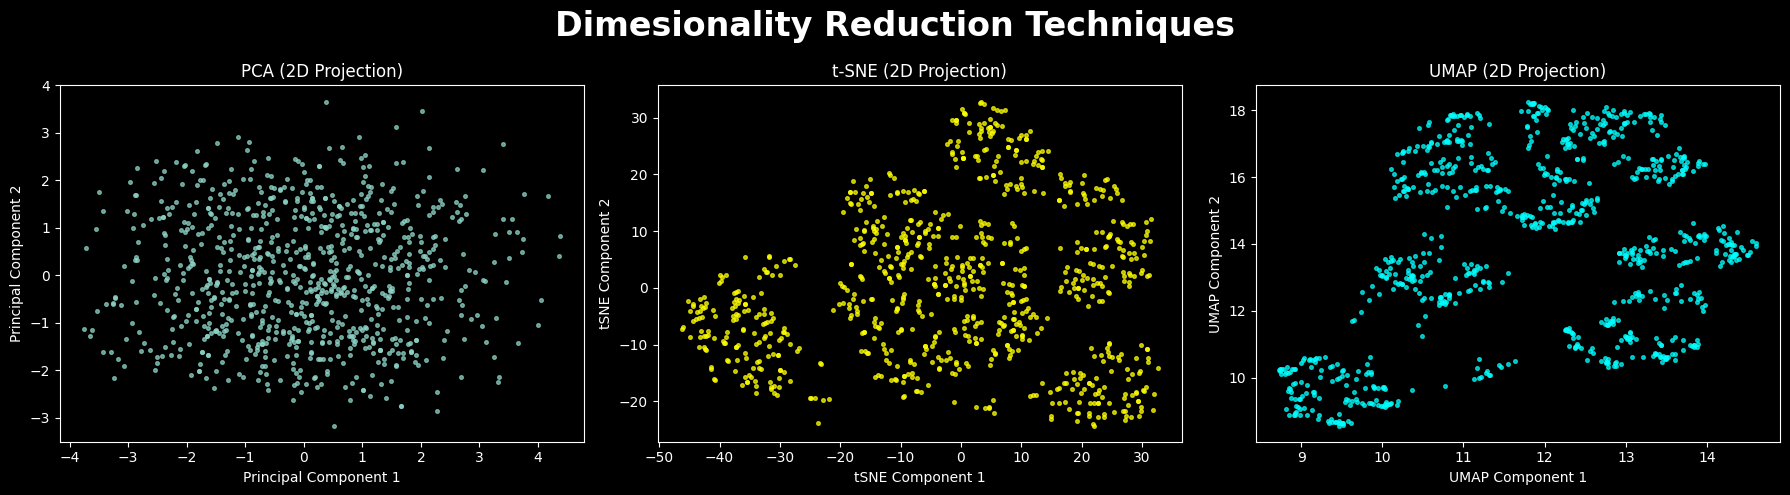

UMAP will be used for our clustering analysis.. reason? just below 👇


In [1129]:
# 5️⃣ Visualizing the techniques
plt.style.use('dark_background')
fig, axes = plt.subplots(1, 3, figsize=(18, 5))
plt.suptitle("Dimesionality Reduction Techniques", fontsize=24, fontweight='bold')

# PCA Plot
axes[0].scatter(pca_result[:, 0], pca_result[:, 1], s=7, alpha=0.7)
axes[0].set_title("PCA (2D Projection)")
axes[0].set_xlabel('Principal Component 1')
axes[0].set_ylabel('Principal Component 2')

# t-SNE Plot
axes[1].scatter(tsne_result[:, 0], tsne_result[:, 1], s=7, alpha=0.7, c='yellow')
axes[1].set_title("t-SNE (2D Projection)")
axes[1].set_xlabel('tSNE Component 1')
axes[1].set_ylabel('tSNE Component 2')

# UMAP Plot
axes[2].scatter(umap_result[:, 0], umap_result[:, 1], s=7, alpha=0.7, c='cyan')
axes[2].set_title("UMAP (2D Projection)")
axes[2].set_xlabel('UMAP Component 1')
axes[2].set_ylabel('UMAP Component 2')

plt.tight_layout()
plt.show()
print("UMAP will be used for our clustering analysis.. reason? just below 👇")

PCA: Produces a dense, overlapping scatter with no clear separation — not ideal for clustering since cluster boundaries are hard to distinguish.

tSNE: Creates well-separated, tight clusters in the 2D projection — good for visualizing and discovering clusters, though distances are not always meaningful.

UMAP: Also shows distinct cluster groupings, but preserves more of the global structure than t-SNE, making it useful for both visualization and some downstream clustering tasks.

### Hunting for the best k

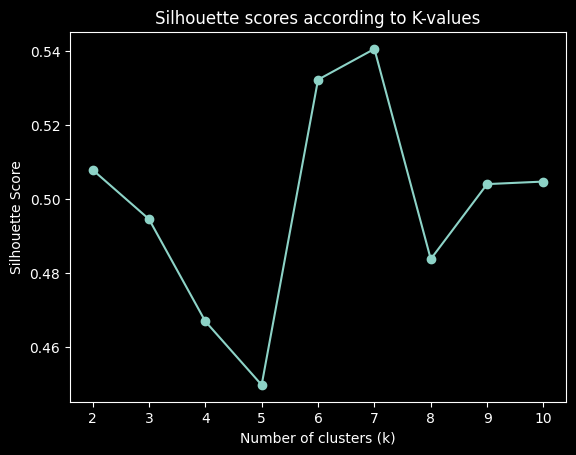

Optimal number of clusters(k): 7
Best Silhouette score: 0.5407


In [1130]:
sil_scores = []
k_values = range(2,11)

for k in k_values:
    kmeans = KMeans(n_clusters=k, random_state=42, n_init='auto')
    labels = kmeans.fit_predict(umap_result)
    sil = silhouette_score(umap_result, labels)
    sil_scores.append(sil)

# Plotting silhouette scores
plt.plot(k_values, sil_scores, marker='o')
plt.xlabel("Number of clusters (k)")
plt.ylabel("Silhouette Score")
plt.title("Silhouette scores according to K-values")
plt.show()

best_k = k_values[sil_scores.index(max(sil_scores))]
print("Optimal number of clusters(k):", best_k)
print(f"Best Silhouette score: {max(sil_scores):.4f}")

### Applying Multiple Clustering Algorithms

In [1131]:
print(f"Applying clustering algorithms with k={best_k}...")

# K-Means Clustering
kmeans = KMeans(n_clusters=best_k, random_state=42, n_init='auto')
kmeans_labels = kmeans.fit_predict(umap_result)

# Agglomerative Clustering
agg = AgglomerativeClustering(n_clusters=best_k, linkage='ward')
agg_labels = agg.fit_predict(umap_result)

# DBSCAN Clustering
dbscan = DBSCAN(eps=0.5, min_samples=5)
dbscan_labels = dbscan.fit_predict(umap_result)

print("\nAll clustering algorithms completed!")

Applying clustering algorithms with k=7...

All clustering algorithms completed!


In [1132]:
print("Clustering Performance Evaluation:")
print("="*42)

# K-Means evaluation
kmeans_score = silhouette_score(umap_result, kmeans_labels)
print(f"K-Means Silhouette Score: {kmeans_score:.4f}")
print(f"K-Means Clusters: {len(np.unique(kmeans_labels))}")

# Agglomerative evaluation
agg_score = silhouette_score(umap_result, agg_labels)
print(f"Agglomerative Silhouette Score: {agg_score:.4f}")
print(f"Agglomerative Clusters: {len(np.unique(agg_labels))}")

# DBSCAN evaluation
dbscan_mask = dbscan_labels != -1  # Exclude noise points
if np.sum(dbscan_mask) > 0:
    dbscan_score = silhouette_score(umap_result[dbscan_mask], dbscan_labels[dbscan_mask])
    unique_dbscan = np.unique(dbscan_labels)
    n_clusters_dbscan = len(unique_dbscan[unique_dbscan != -1])
    n_noise = np.sum(dbscan_labels == -1)
    
    print(f"DBSCAN Silhouette Score: {dbscan_score:.4f}")
    print(f"DBSCAN Clusters: {n_clusters_dbscan}")
    print(f"DBSCAN Noise Points: {n_noise}")
else:
    print("DBSCAN: No valid clusters found")

print("-"*69)
print("\nK-Means is the winner 🥇\nIt will be used for the persona analysis")

Clustering Performance Evaluation:
K-Means Silhouette Score: 0.5407
K-Means Clusters: 7
Agglomerative Silhouette Score: 0.5291
Agglomerative Clusters: 7
DBSCAN Silhouette Score: 0.4824
DBSCAN Clusters: 6
DBSCAN Noise Points: 3
---------------------------------------------------------------------

K-Means is the winner 🥇
It will be used for the persona analysis


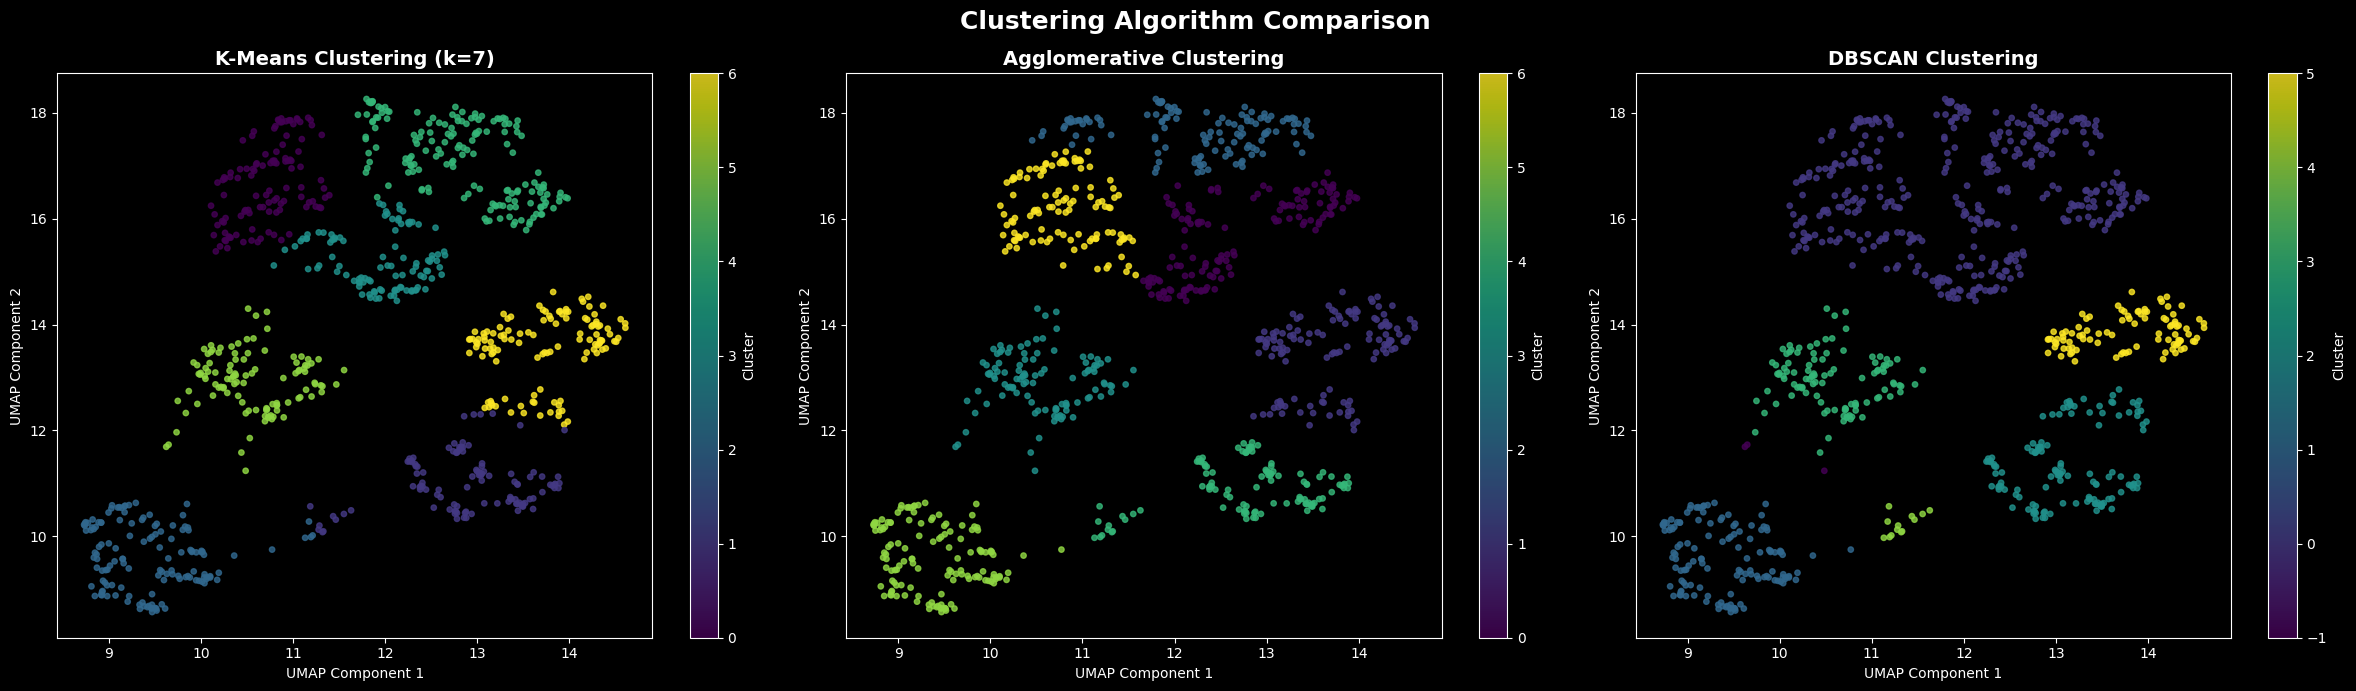

Clustering visualization completed✅
Final verdict: K-Means with 7 clusters is best for this Mental Health Persona Analysis


In [1133]:
fig, (ax1, ax2, ax3) = plt.subplots(1, 3, figsize=(24, 7))

# K-Means Visualization
scatter1 = ax1.scatter(umap_result[:, 0], umap_result[:, 1], c=kmeans_labels, cmap='viridis', s=15, alpha=0.8)
ax1.set_title(f'K-Means Clustering (k={best_k})', fontsize=14, fontweight='bold')
ax1.set_xlabel('UMAP Component 1')
ax1.set_ylabel('UMAP Component 2')
plt.colorbar(scatter1, ax=ax1, label='Cluster')

# Agglomerative Visualization
scatter2 = ax2.scatter(umap_result[:, 0], umap_result[:, 1], c=agg_labels, cmap='viridis', s=15, alpha=0.8)
ax2.set_title('Agglomerative Clustering', fontsize=14, fontweight='bold')
ax2.set_xlabel('UMAP Component 1')
ax2.set_ylabel('UMAP Component 2')
plt.colorbar(scatter2, ax=ax2, label='Cluster')

# DBSCAN Visualization
scatter3 = ax3.scatter(umap_result[:, 0], umap_result[:, 1], c=dbscan_labels, cmap='viridis', s=15, alpha=0.8)
ax3.set_title('DBSCAN Clustering', fontsize=14, fontweight='bold')
ax3.set_xlabel('UMAP Component 1')
ax3.set_ylabel('UMAP Component 2')
plt.colorbar(scatter3, ax=ax3, label='Cluster')

plt.suptitle('Clustering Algorithm Comparison', fontsize=18, fontweight='bold')
plt.tight_layout()
plt.show()

print("Clustering visualization completed✅")
print(f"Final verdict: K-Means with {best_k} clusters is best for this Mental Health Persona Analysis")

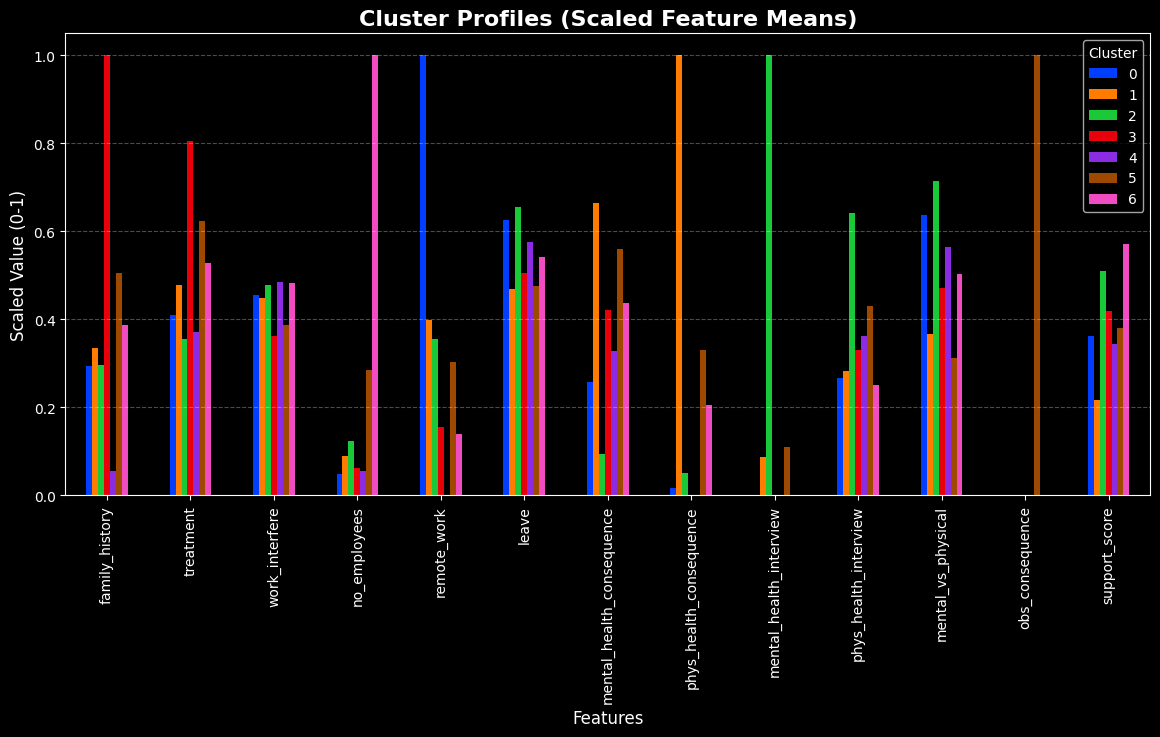

In [ ]:
from sklearn.preprocessing import MinMaxScaler
import seaborn as sns

df_new = pd.DataFrame(scaled_data, columns=df_scaled.columns)
df_new['cluster'] = kmeans.labels_

#Scale features to 0–1 range for fair comparison in the plot
scaler = MinMaxScaler()
features_only = df_new.drop(columns=['cluster'])
scaled_array = scaler.fit_transform(features_only)

scaled_df = pd.DataFrame(scaled_array, columns=features_only.columns)
scaled_df['cluster'] = df_new['cluster']

#Get mean scaled value of each feature per cluster
cluster_summary = scaled_df.groupby('cluster').mean()

cluster_summary.T.plot(kind='bar', figsize=(14, 6), color=sns.set_palette('bright'))
plt.title("Cluster Profiles",fontsize=16, fontweight='bold')
plt.ylabel("Scaled Value (0-1)",fontsize=12)
plt.xlabel("Features",fontsize=12)
plt.legend(title='Cluster')
plt.grid(True, axis='y', linestyle='--', alpha=0.3)
#plt.tight_layout()
plt.show()


## Results Summary

### Key Findings
1. **Optimal Clustering** – K-Means with 7 clusters provided the most meaningful segmentation, supported by silhouette analysis and distinct feature profiles.
2. **Clear Personas** – Analysis of the UMAP clusters revealed unique combinations of workplace attitudes, mental health openness, and support perceptions for each cluster.
3. **Actionable Insights** – Distinct groups can be targeted with tailored HR interventions, improving engagement and reducing untreated mental health issues.


---

### Technical Performance
- **Best Algorithm:** K-Means clustering  
- **Best Dimensionality Reduction Technique:** UMAP
- **Feature Scaling:** MinMaxScaler for cross-feature comparability and StandardScaler for normal feature scaling 
- **Cluster Validation:** Best cluster algo selected with the help of Silhouette score 

---

## 7 Distinct Mental Health Personas in Techies

Based on the clustering patterns and scaled bar chart analysis:

**Cluster 0 – Balanced Support Seekers**  
Progressive yet moderate across all dimensions. Likely to participate in programs but not actively lead initiatives.

**Cluster 1 – Cautious Engagers**  
Low openness and remote work participation, moderate treatment rates. Engage only when trust is established.

**Cluster 2 – Policy-Dependent Advocates**  
Highly responsive to strong workplace benefits and leave policies. Thrive in structured, supportive environments.

**Cluster 3 – High-Risk Silent Sufferers**  
Strong treatment and family history indicators but low support scores. May avoid disclosure due to perceived stigma.

**Cluster 4 – Under-Supported Reluctants**  
Experience consequences without adequate access to treatment or leave. Likely constrained by organizational gaps.

**Cluster 5 – Stigma-Affected Minimalists**  
Engage little with mental health resources despite some awareness of physical health consequences.

**Cluster 6 – Empowered Open Advocates**  
High support scores, confident use of leave, and strong openness. Natural champions for wellness advocacy.

---

### Conclusion
This analysis successfully identified **7 clear mental health personas** in the tech workforce using this unsupervised learning technique called K-Means clustering with a big help from UMAP.

**Impact:**  
Enables organizations to update mental-health-wellness programs with nuanced, persona-driven strategies. This maximizes engagement, reduces untreated mental health cases, and strengthens workplace culture.

---
---

## Thank You!